Sparse Principal Components Analysis (SparsePCA).

Finds the set of sparse components that can optimally reconstruct the data. The amount of sparseness is controllable by the coefficient of the L1 penalty, given by the parameter alpha.

more [here]()

SparsePCA is a variant of PCA, with the goal of extracting the set of sparse components that best reconstruct the data.

Mini-batch sparse PCA (MiniBatchSparsePCA) is a variant of SparsePCA that is faster but less accurate. The increased speed is reached by iterating over small chunks of the set of features, for a given number of iterations.

Principal component analysis (PCA) has the disadvantage that the components extracted by this method have exclusively dense expressions, i.e. they have non-zero coefficients when expressed as linear combinations of the original variables. This can make interpretation difficult. In many cases, the real underlying components can be more naturally imagined as sparse vectors; for example in face recognition, components might naturally map to parts of faces.

Sparse principal components yields a more parsimonious, interpretable representation, clearly emphasizing which of the original features contribute to the differences between samples.

The following example illustrates 16 components extracted using sparse PCA from the Olivetti faces dataset. It can be seen how the regularization term induces many zeros. Furthermore, the natural structure of the data causes the non-zero coefficients to be vertically adjacent. The model does not enforce this mathematically: each component is a vector  , and there is no notion of vertical adjacency except during the human-friendly visualization as 64x64 pixel images. The fact that the components shown below appear local is the effect of the inherent structure of the data, which makes such local patterns minimize reconstruction error. There exist sparsity-inducing norms that take into account adjacency and different kinds of structure; see [Jen09](https://scikit-learn.org/stable/modules/decomposition.html#jen09) for a review of such methods. For more details on how to use Sparse PCA, see the Examples section, below.

[sklearn.decomposition.SparsePCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Sparse PCA

In [8]:
class ModelSPCA:
    
    def __init__(self, n_components):
        self.n_components=n_components
        
    # spe: squared prediction errors
    def spe(self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)        
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        if self.n_components == 0:
            self.m = sklearn.decomposition.SparsePCA()
        else:
            self.m = sklearn.decomposition.SparsePCA(n_components=self.n_components)
            # Learn the inverse transform for non-precomputed kernels (i.e. learn
            # to find the pre-image of a point). This method is based on [2]
           
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        
        # fit the model
        self.m.fit_transform(X_train) # only condition that can make sparse works
        
        # Manual Inverse Transform 
        dt_red = np.dot(X_train - self.m.mean_, self.m.components_.T)
        X_train_pred = np.dot(dt_red, self.m.components_) + self.m.mean_
        # X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test - self.mu_train) / self.std_train) 
        dt_red = np.dot(X_test - self.m.mean_, self.m.components_.T)
        X_test_pred = np.dot(dt_red, self.m.components_) + self.m.mean_
        # X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training the Data

In [9]:
models = {'SPCA': ModelSPCA(0)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [10]:
detection_limits

{'SPCA': 3.8079592972883005e-07}

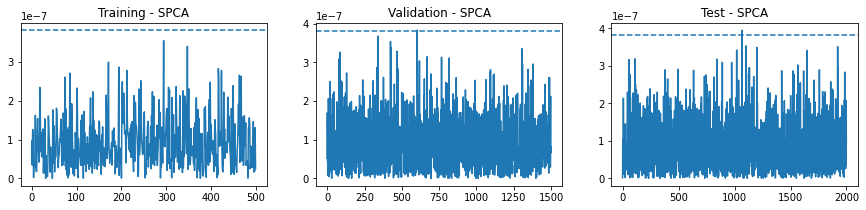

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - SPCA')
plt.axhline(detection_limits['SPCA'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - SPCA')
plt.axhline(detection_limits['SPCA'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - SPCA')
plt.axhline(detection_limits['SPCA'], ls = '--')

# Testing the Data

SPCA    0.0
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
SPCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


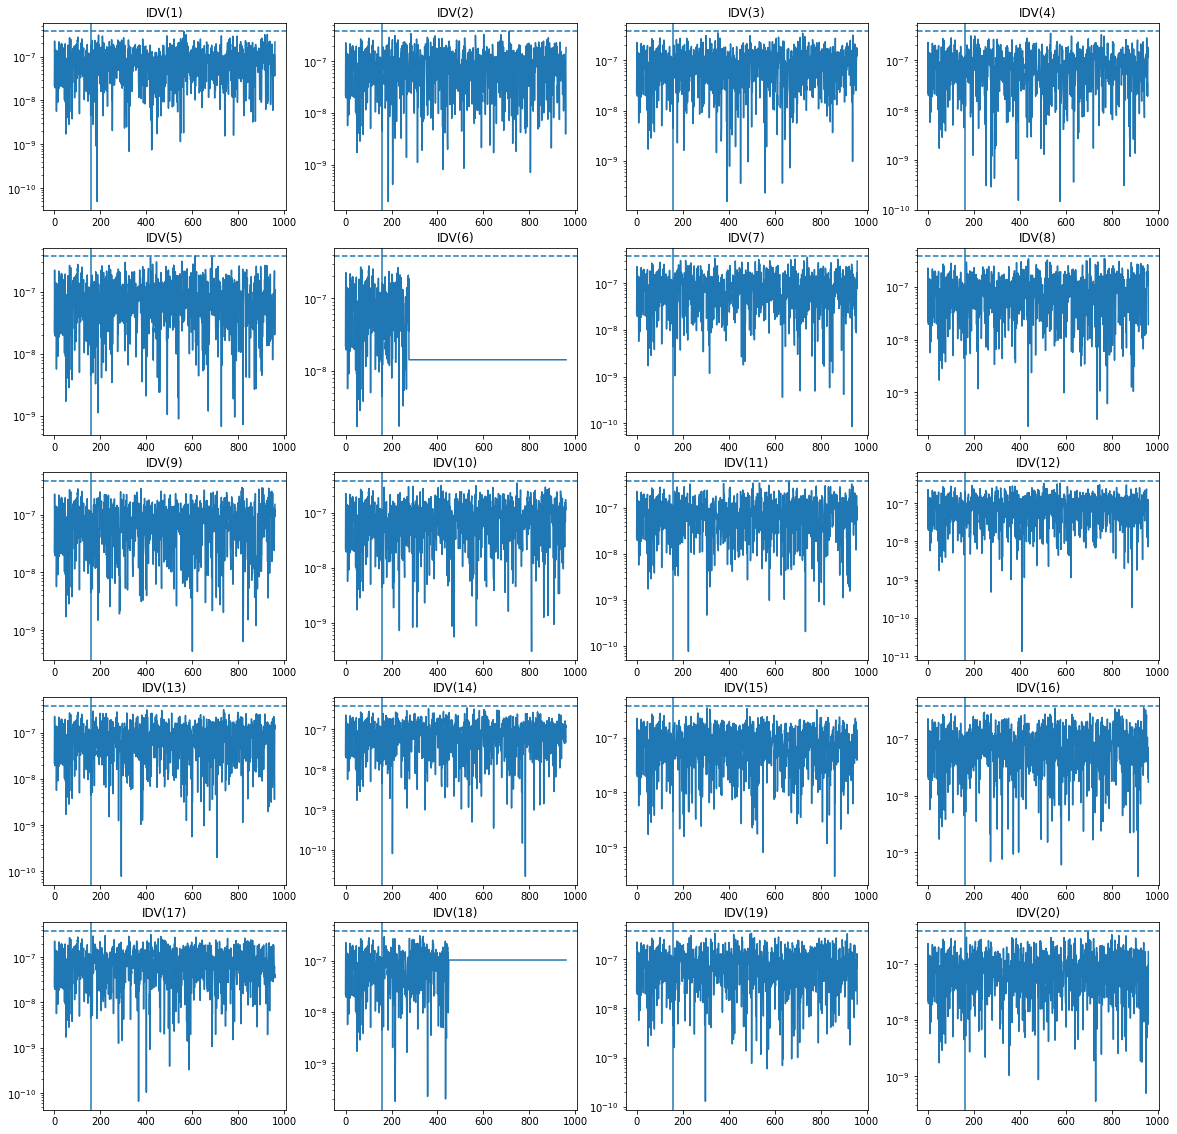

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

# Training the data with 30 n_components in the model

In [13]:
models = {'SPCA30': ModelSPCA(30)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [14]:
detection_limits

{'SPCA30': 30.883000744894083}

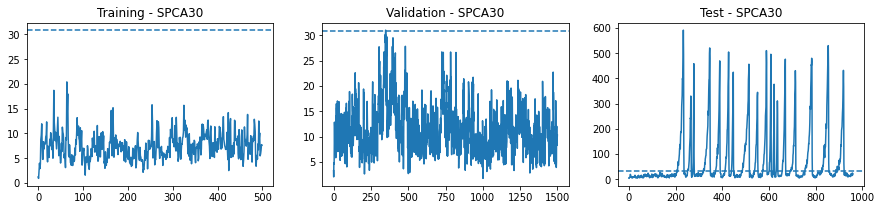

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - SPCA30')
plt.axhline(detection_limits['SPCA30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - SPCA30')
plt.axhline(detection_limits['SPCA30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - SPCA30')
plt.axhline(detection_limits['SPCA30'], ls = '--')

# Testing the new model

SPCA30    56.41875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
SPCA30,99.625,96.875,0.125,64.0,26.125,100.0,99.875,96.5,0.125,10.75,24.875,97.75,91.0,86.125,0.125,16.25,80.75,92.375,0.875,44.25


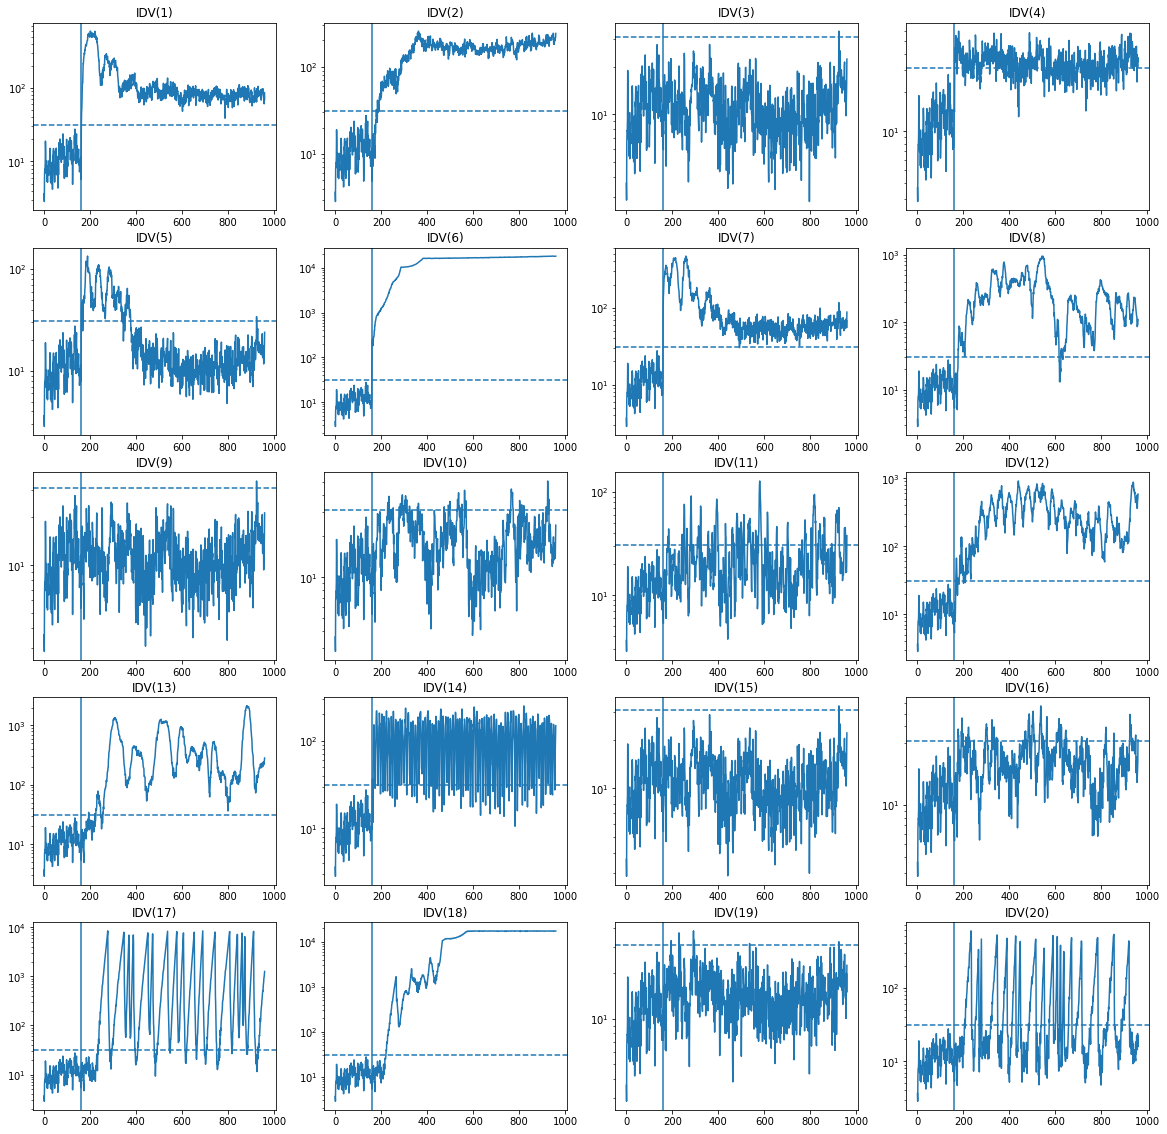

In [16]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [17]:
# fdr_df.to_csv('./experimental_result_csv/spca30.csv')

## Lag variables

In [18]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [19]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Adding lag variables

spca_lag1    59.512500
spca_lag2    60.888611
spca_lag3    59.699248
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
spca_lag1,99.500000,98.000000,0.0,97.625000,25.375000,100.0,100.0,95.125000,0.0,4.875000,55.250000,98.000000,90.625000,99.875,0.0,10.375000,80.250000,92.125000,1.125000,42.125000
spca_lag2,99.624531,98.122653,0.0,99.874844,26.282854,100.0,100.0,97.246558,0.0,6.508135,62.703379,98.748436,91.989987,100.000,0.0,13.141427,81.602003,92.240300,4.255319,45.431790
spca_lag3,99.624060,98.245614,0.0,99.498747,24.185464,100.0,100.0,97.117794,0.0,3.508772,59.022556,98.621554,91.228070,100.000,0.0,4.887218,80.952381,92.230576,0.751880,44.110276


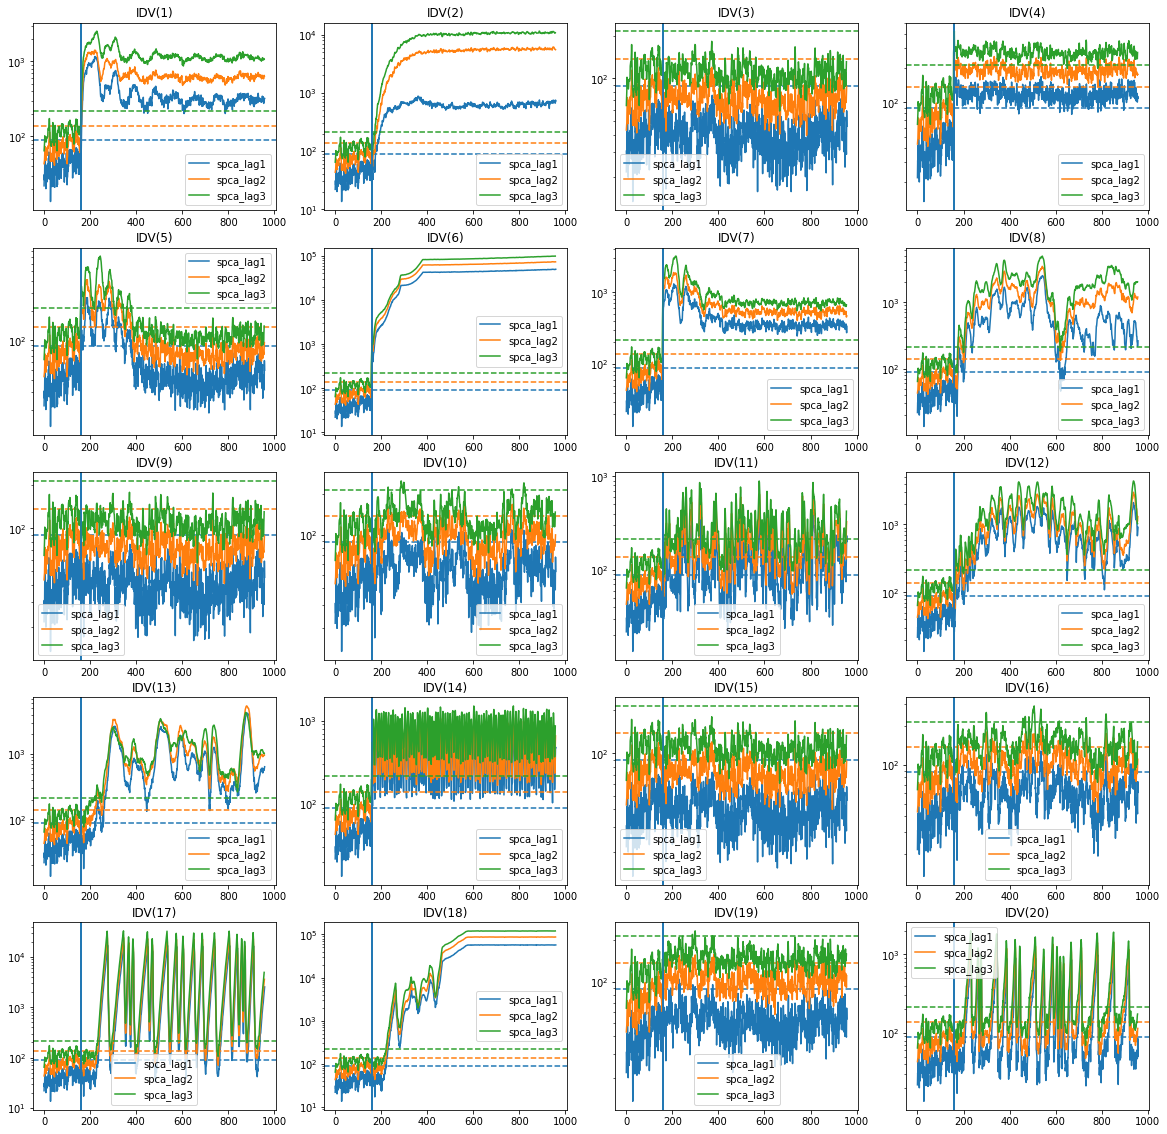

In [20]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'spca_lag1': ModelSPCA(30), 'spca_lag2': ModelSPCA(30), 'spca_lag3': ModelSPCA(30)}
lags = {'spca_lag1': 1, 'spca_lag2': 2, 'spca_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [21]:
# fdr_df.to_csv('./experimental_result_csv/spcalag.csv')

## Filter noise

WS_10     55.1625
WS_50     55.8000
WS_100    56.3250
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.00,97.875,0.0,99.125,35.750,99.750,99.750,97.25,0.0,9.250,33.625,97.875,92.000,0.625,0.0,7.75,87.875,92.375,0.0,53.375
WS_50,98.00,94.500,0.0,97.625,98.000,98.875,99.125,92.50,0.0,2.375,22.875,84.750,88.750,0.000,0.0,0.00,89.750,91.125,0.0,57.750
WS_100,98.25,96.000,0.0,96.500,97.375,99.125,98.625,94.25,0.0,0.000,5.875,79.125,88.625,0.000,0.0,0.00,89.750,90.875,0.0,92.125


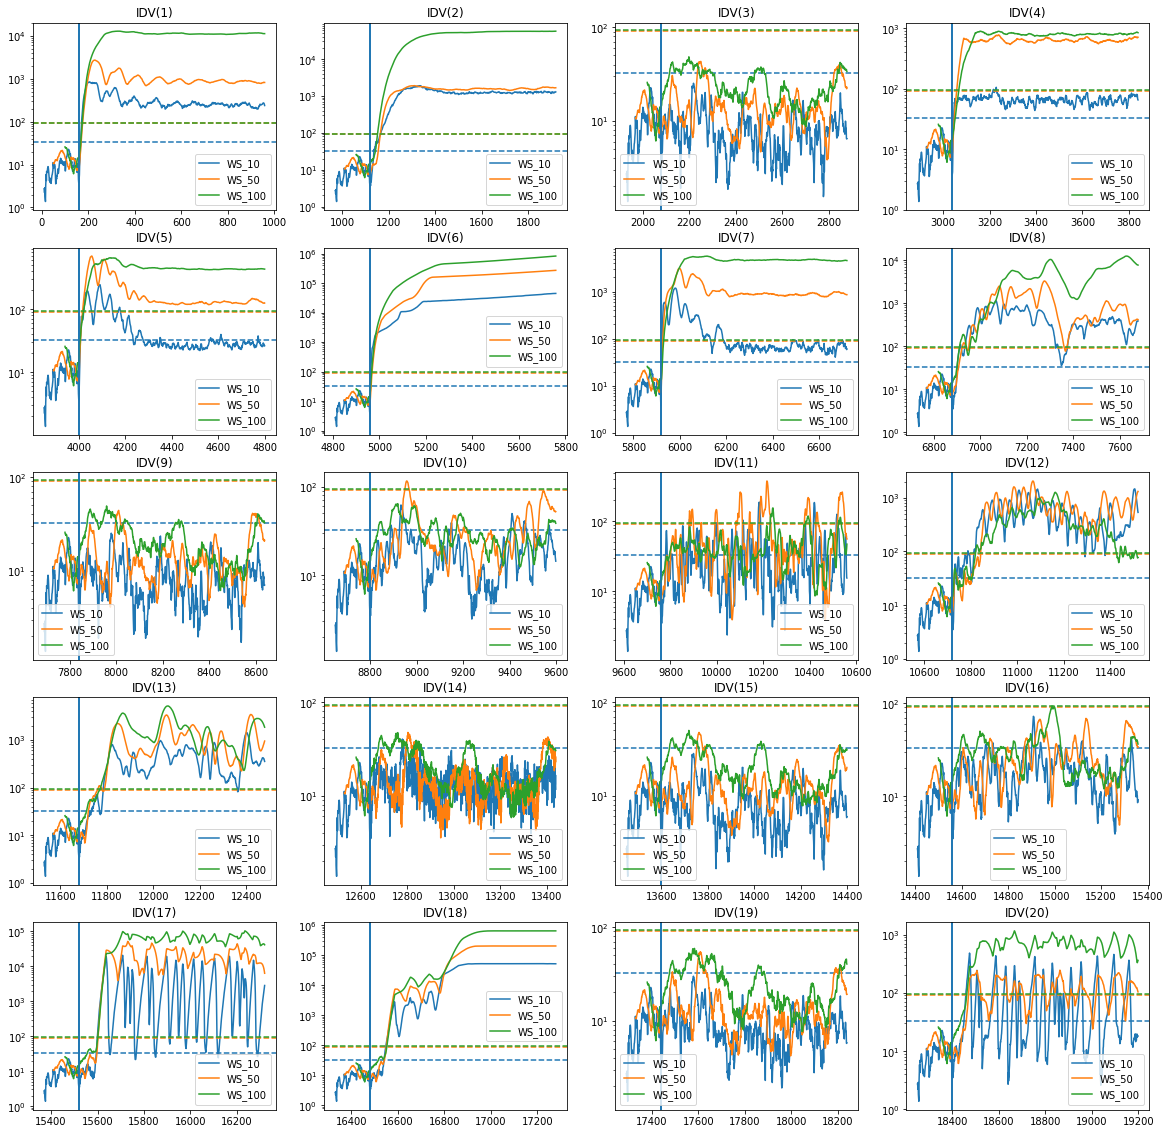

In [22]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelSPCA(30), 'WS_50': ModelSPCA(30), 'WS_100': ModelSPCA(30)}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [23]:
# fdr_df.to_csv('./experimental_result_csv/spcanf.csv')